In [ ]:
# ============================================================
# HUMAN ACTIVITY RECOGNITION - CMPE 287
# Team: SANNS
# Members: Salma Ibrahim, Sana Al Hamimidi, Akmal Shaikh, Nicholas Faylor, Noah Scheuerman
# Date: 11/14/2025
# ============================================================

"""
This project classifies 18 different human activities using smartphone 
sensor data (accelerometer and gyroscope) from the KU-HAR dataset.

We use two machine learning models:
1. Random Forest Classifier
2. Support Vector Machine (SVM)

Dataset: 20,750 samples from 90 participants
Activities: Walking, Running, Sitting, Standing, Jumping, etc.
"""

# ============================================================
# SECTION 1: SETUP & IMPORTS
# ============================================================

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Model Selection
from sklearn.model_selection import train_test_split

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler

# Machine Learning - Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Machine Learning - Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")
print(f"✓ Random state set to: {RANDOM_STATE}")
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")
print("\nReady to load data!")

In [ ]:
# ============================================================
# SECTION 2: LOAD DATASET
# ============================================================

# Define activity labels (Class IDs 0-17)
activity_names = {
    0: 'Stand',
    1: 'Sit',
    2: 'Talk-sit',
    3: 'Talk-stand',
    4: 'Stand-sit',
    5: 'Lay',
    6: 'Lay-stand',
    7: 'Pick',
    8: 'Jump',
    9: 'Push-up',
    10: 'Sit-up',
    11: 'Walk',
    12: 'Walk-backward',
    13: 'Walk-circle',
    14: 'Run',
    15: 'Stair-up',
    16: 'Stair-down',
    17: 'Table-tennis'
}

print("Loading KU-HAR Time Domain Subsamples dataset...")
print("=" * 60)

# Load the dataset (no header in CSV)
# NOTE: Update the path to match where you saved the CSV file
df = pd.read_csv('data/time_domain_subsamples.csv', header=None)

print(f"✓ Dataset loaded successfully!")
print(f"\nDataset Shape: {df.shape}")
print(f"  - Total samples: {df.shape[0]:,}")
print(f"  - Total columns: {df.shape[1]:,}")

# Extract labels (column 1800 contains class IDs 0-17)
labels = df.iloc[:, 1800]

print(f"\n{'Activity Distribution:'}")
print("=" * 60)
class_distribution = labels.value_counts().sort_index()

for class_id, count in class_distribution.items():
    activity_name = activity_names[class_id]
    percentage = (count / len(labels)) * 100
    print(f"  {class_id:2d}. {activity_name:15s}: {count:4d} samples ({percentage:5.2f}%)")

print(f"\n{'Dataset Summary:'}")
print("=" * 60)
print(f"  - Sensor readings per sample: 1,800 (300 points × 6 axes)")
print(f"  - Sampling rate: 100 Hz")
print(f"  - Window duration: 3 seconds")
print(f"  - Number of activities: 18")
print(f"  - Total participants: 90")

# Verify data structure
print(f"\n{'Data Structure Verification:'}")
print("=" * 60)
print(f"  - Columns 0-299:      Accelerometer X")
print(f"  - Columns 300-599:    Accelerometer Y")
print(f"  - Columns 600-899:    Accelerometer Z")
print(f"  - Columns 900-1199:   Gyroscope X")
print(f"  - Columns 1200-1499:  Gyroscope Y")
print(f"  - Columns 1500-1799:  Gyroscope Z")
print(f"  - Column 1800:        Class ID (0-17)")
print(f"  - Column 1801:        Data length")
print(f"  - Column 1802:        Serial number")

print("\n✓ Ready for feature extraction!")

In [ ]:
# ============================================================
# SECTION 3: FEATURE EXTRACTION
# ============================================================

print("Starting feature extraction...")
print("=" * 60)
print("Converting 1,800 raw sensor values per sample into 24 statistical features")
print()

def extract_features(row):
    """
    Extract statistical features from time-series sensor data.
    
    For each of the 6 sensor axes (Accel X/Y/Z, Gyro X/Y/Z), we extract:
    - Mean: Average value over 3 seconds
    - Std: Standard deviation (variability)
    - Max: Maximum value
    - Min: Minimum value
    
    Total: 6 axes × 4 statistics = 24 features
    """
    features = {}
    
    # Accelerometer X (columns 0-299)
    accel_x = row[0:300].values
    features['accel_x_mean'] = np.mean(accel_x)
    features['accel_x_std'] = np.std(accel_x)
    features['accel_x_max'] = np.max(accel_x)
    features['accel_x_min'] = np.min(accel_x)
    
    # Accelerometer Y (columns 300-599)
    accel_y = row[300:600].values
    features['accel_y_mean'] = np.mean(accel_y)
    features['accel_y_std'] = np.std(accel_y)
    features['accel_y_max'] = np.max(accel_y)
    features['accel_y_min'] = np.min(accel_y)
    
    # Accelerometer Z (columns 600-899)
    accel_z = row[600:900].values
    features['accel_z_mean'] = np.mean(accel_z)
    features['accel_z_std'] = np.std(accel_z)
    features['accel_z_max'] = np.max(accel_z)
    features['accel_z_min'] = np.min(accel_z)
    
    # Gyroscope X (columns 900-1199)
    gyro_x = row[900:1200].values
    features['gyro_x_mean'] = np.mean(gyro_x)
    features['gyro_x_std'] = np.std(gyro_x)
    features['gyro_x_max'] = np.max(gyro_x)
    features['gyro_x_min'] = np.min(gyro_x)
    
    # Gyroscope Y (columns 1200-1499)
    gyro_y = row[1200:1500].values
    features['gyro_y_mean'] = np.mean(gyro_y)
    features['gyro_y_std'] = np.std(gyro_y)
    features['gyro_y_max'] = np.max(gyro_y)
    features['gyro_y_min'] = np.min(gyro_y)
    
    # Gyroscope Z (columns 1500-1799)
    gyro_z = row[1500:1800].values
    features['gyro_z_mean'] = np.mean(gyro_z)
    features['gyro_z_std'] = np.std(gyro_z)
    features['gyro_z_max'] = np.max(gyro_z)
    features['gyro_z_min'] = np.min(gyro_z)
    
    return features

# Extract features for all samples
print("Extracting features from all 20,750 samples...")
print("This may take a minute or two...\n")

feature_list = []
total_samples = len(df)

for idx, row in df.iterrows():
    feature_list.append(extract_features(row))
    
    # Progress update every 5,000 samples
    if (idx + 1) % 5000 == 0:
        progress = ((idx + 1) / total_samples) * 100
        print(f"  Progress: {idx + 1:,}/{total_samples:,} samples ({progress:.1f}%)")

print(f"  Progress: {total_samples:,}/{total_samples:,} samples (100.0%)")

# Create feature DataFrame
features_df = pd.DataFrame(feature_list)

print(f"\n✓ Feature extraction complete!")
print("=" * 60)
print(f"Feature Matrix Shape: {features_df.shape}")
print(f"  - Samples: {features_df.shape[0]:,}")
print(f"  - Features per sample: {features_df.shape[1]}")

print(f"\nExtracted Features:")
print("-" * 60)
for i, col in enumerate(features_df.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\nFeature Statistics (first 5 features):")
print("-" * 60)
print(features_df.iloc[:, :5].describe())

print("\n✓ Ready for train-test split!")

In [ ]:
# ============================================================
# SECTION 4: TRAIN-TEST SPLIT
# ============================================================

print("Splitting data into training and testing sets...")
print("=" * 60)

# Split: 80% training, 20% testing
# Stratify ensures each activity is proportionally represented in both sets
X_train, X_test, y_train, y_test = train_test_split(
    features_df,           # Feature matrix (24 features)
    labels,                # Class labels (0-17)
    test_size=0.2,         # 20% for testing
    stratify=labels,       # Maintain class distribution
    random_state=RANDOM_STATE  # Reproducibility
)

print(f"✓ Data split complete!")
print()

# Display split information
print(f"{'Dataset Split Summary:'}")
print("-" * 60)
print(f"  Training samples:   {len(X_train):,} ({len(X_train)/len(features_df)*100:.1f}%)")
print(f"  Testing samples:    {len(X_test):,} ({len(X_test)/len(features_df)*100:.1f}%)")
print(f"  Total samples:      {len(features_df):,}")
print()
print(f"  Features per sample: {X_train.shape[1]}")

# Verify stratification worked - show class distribution in train/test
print(f"\n{'Class Distribution Verification:'}")
print("=" * 60)
print(f"{'Activity':<20} {'Train Count':<15} {'Test Count':<15} {'Train %':<10} {'Test %'}")
print("-" * 60)

train_dist = y_train.value_counts().sort_index()
test_dist = y_test.value_counts().sort_index()

for class_id in range(18):
    activity = activity_names[class_id]
    train_count = train_dist.get(class_id, 0)
    test_count = test_dist.get(class_id, 0)
    train_pct = (train_count / len(y_train)) * 100
    test_pct = (test_count / len(y_test)) * 100
    
    print(f"{activity:<20} {train_count:<15} {test_count:<15} {train_pct:<10.2f} {test_pct:.2f}")

print()
print("✓ Stratification successful - distributions are proportional!")
print("\n✓ Ready for feature scaling!")


In [ ]:
# ============================================================
# SECTION 5: FEATURE SCALING (FIXED WITH ROBUST SCALER)
# ============================================================

from sklearn.preprocessing import RobustScaler

print("Scaling features using RobustScaler...")
print("=" * 60)
print("Why RobustScaler? It handles outliers better than StandardScaler.")
print("Uses median and IQR instead of mean and std.\n")

# Initialize RobustScaler (robust to outliers)
scaler = RobustScaler()

# Fit on training data only, then transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Feature scaling complete!")
print()

# Show scaling effect
print(f"{'Scaling Effect (example: accel_x_mean):'}")
print("-" * 60)
print(f"Before scaling:")
print(f"  Training median: {X_train.iloc[:, 0].median():.4f}")
print(f"  Training IQR:    {X_train.iloc[:, 0].quantile(0.75) - X_train.iloc[:, 0].quantile(0.25):.4f}")
print()
print(f"After scaling:")
print(f"  Training median: {X_train_scaled[:, 0].mean():.4f}")
print(f"  Data range: [{X_train_scaled.min():.4f}, {X_train_scaled.max():.4f}]")
print()
print("Features now scaled robustly (handles outliers)")

print("\n✓ Ready to train models!")

In [ ]:
# ============================================================
# SECTION 6: TRAIN RANDOM FOREST MODEL
# ============================================================

print("Training Random Forest Classifier...")
print("=" * 60)

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,        # 100 decision trees
    max_depth=None,          # No limit on tree depth
    min_samples_split=2,     # Minimum samples to split a node
    random_state=RANDOM_STATE,
    n_jobs=-1                # Use all CPU cores
)

print(f"Model configuration:")
print(f"  - Number of trees: 100")
print(f"  - Max depth: Unlimited")
print(f"  - Random state: {RANDOM_STATE}")
print()

# Train the model
print("Training in progress...")
import time
start_time = time.time()

rf_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"✓ Training complete! Time: {training_time:.2f} seconds")
print()

# Make predictions
print("Making predictions on test set...")
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)

print("✓ Predictions complete!")
print()

# Quick accuracy preview
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("=" * 60)
print(f"RANDOM FOREST - QUICK PREVIEW")
print("=" * 60)
print(f"Test Set Accuracy: {rf_accuracy*100:.2f}%")
print()
print("(Detailed evaluation in next sections)")

print("\n✓ Random Forest model trained successfully!")
print("✓ Ready to train SVM model!")

In [ ]:
# ============================================================
# SECTION 7: TRAIN SVM MODEL (WITH ROBUST SCALING)
# ============================================================

print("Training SVM Classifier (with RobustScaler data)...")
print("=" * 60)

# Use linear kernel - simpler and more stable
svm_model = SVC(
    kernel='linear',
    C=1.0,
    random_state=RANDOM_STATE,
    max_iter=5000
)

print(f"Model configuration:")
print(f"  - Kernel: Linear")
print(f"  - C: 1.0")
print(f"  - Data: RobustScaler (handles outliers)")
print()

# Train
print("Training in progress...")
start_time = time.time()

svm_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"✓ Training complete! Time: {training_time:.2f} seconds")
print()

# Predict
print("Making predictions on test set...")
y_pred_svm = svm_model.predict(X_test_scaled)

print("✓ Predictions complete!")
print()

# Accuracy
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print("=" * 60)
print(f"SVM - RESULTS")
print("=" * 60)
print(f"Test Set Accuracy: {svm_accuracy*100:.2f}%")
print(f"Classes predicted: {len(np.unique(y_pred_svm))}/18")
print()

# Compare
print("=" * 60)
print(f"MODEL COMPARISON")
print("=" * 60)
print(f"Random Forest Accuracy: {rf_accuracy*100:.2f}%")
print(f"SVM Accuracy:           {svm_accuracy*100:.2f}%")
print(f"Difference:             {abs(rf_accuracy - svm_accuracy)*100:.2f}%")

if rf_accuracy > svm_accuracy:
    print(f"\n→ Random Forest performs better by {(rf_accuracy - svm_accuracy)*100:.2f}%")
elif svm_accuracy > rf_accuracy:
    print(f"\n→ SVM performs better by {(svm_accuracy - rf_accuracy)*100:.2f}%")

print("\n✓ Both models trained successfully!")

In [ ]:
# ============================================================
# SECTION 8: TRAIN NAIVE BAYES MODEL
# ============================================================

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

print("Training Naive Bayes Classifier...")
print("=" * 60)

# ============================================================
# IMPORTANT: NAIVE BAYES REQUIRES STANDARDSCALER
# ============================================================
# Naive Bayes assumes features follow Gaussian distributions.
# StandardScaler (z-score normalization) preserves the Gaussian
# shape while normalizing to mean=0, std=1, which is ideal for NB.
# 
# Other scalers tested:
#   - RobustScaler: 28.41% (median/IQR distorts distributions)
#   - No scaling: 54.94% (features at different scales)
#   - StandardScaler: 61.47% ✓ (best for Gaussian assumption)
# ============================================================

print("Note: Using StandardScaler for Naive Bayes (optimal for Gaussian assumption)")
print()

# Create StandardScaler specifically for Naive Bayes
scaler_nb = StandardScaler()

# Scale training data
X_train_nb_scaled = scaler_nb.fit_transform(X_train)

# Scale test data using the same scaler
X_test_nb_scaled = scaler_nb.transform(X_test)

print("✓ Features scaled using StandardScaler (z-score normalization)")
print()

# Initialize Naive Bayes
nb_model = GaussianNB()

print(f"Model configuration:")
print(f"  - Algorithm: Gaussian Naive Bayes")
print(f"  - Scaling: StandardScaler (mean=0, std=1)")
print(f"  - Assumes features follow normal distribution")
print()

# Train the model
print("Training in progress...")
start_time = time.time()

nb_model.fit(X_train_nb_scaled, y_train)

nb_training_time = time.time() - start_time
print(f"✓ Training complete! Time: {nb_training_time:.2f} seconds")
print()

# Make predictions
print("Making predictions on test set...")
y_pred_nb = nb_model.predict(X_test_nb_scaled)

print("✓ Predictions complete!")
print()

# Quick accuracy preview
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print("=" * 60)
print(f"NAIVE BAYES - QUICK PREVIEW")
print("=" * 60)
print(f"Scaling Method:    StandardScaler")
print(f"Test Set Accuracy: {nb_accuracy*100:.2f}%")
print()
print("Note: NB's moderate performance (~61%) is expected for HAR tasks")
print("      due to violated feature independence assumptions.")
print()
print("(Detailed evaluation in next sections)")

print("\n✓ Naive Bayes model trained successfully!")
print("✓ Ready to train AdaBoost!")

In [ ]:
# ============================================================
# SECTION 9: TRAIN ADABOOST MODEL
# ============================================================

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

print("Training AdaBoost Classifier...")
print("=" * 60)

# ============================================================
# OPTIMAL CONFIGURATION FOR ADABOOST
# ============================================================
# After testing multiple configurations, we found:
#   - Default (lr=1.0, depth=1): 52.77% - too simple
#   - Balanced (lr=0.5, depth=3): 80.75% ✓ BEST
#   - More Trees (lr=0.1, n=200): 80.48% - similar but slower
#
# Best config: learning_rate=0.5, max_depth=3, n_estimators=100
# This balances accuracy, training time, and generalization.
# ============================================================

# Create base estimator with optimal depth
base_estimator = DecisionTreeClassifier(
    max_depth=3,
    random_state=RANDOM_STATE
)

# Initialize AdaBoost with optimal hyperparameters
ada_model = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=100,
    learning_rate=0.5,
    random_state=RANDOM_STATE
)

print(f"Model configuration:")
print(f"  - Number of estimators: 100")
print(f"  - Learning rate: 0.5")
print(f"  - Base estimator: Decision Tree (max_depth=3)")
print(f"  - Random state: {RANDOM_STATE}")
print()

# Train the model
print("Training in progress...")
print("Note: AdaBoost trains sequentially (may take ~20 seconds)...")
start_time = time.time()

ada_model.fit(X_train, y_train)  # Using unscaled data (best for tree-based models)

ada_training_time = time.time() - start_time
print(f"✓ Training complete! Time: {ada_training_time:.2f} seconds")
print()

# Make predictions
print("Making predictions on test set...")
y_pred_ada = ada_model.predict(X_test)

print("✓ Predictions complete!")
print()

# Quick accuracy preview
ada_accuracy = accuracy_score(y_test, y_pred_ada)
print("=" * 60)
print(f"ADABOOST - QUICK PREVIEW")
print("=" * 60)
print(f"Configuration:     Balanced (lr=0.5, depth=3)")
print(f"Test Set Accuracy: {ada_accuracy*100:.2f}%")
print(f"Training Time:     {ada_training_time:.2f} seconds")
print()
print("Note: AdaBoost with depth=3 trees significantly outperforms")
print("      default stumps (depth=1), achieving 80.75% vs 52.77%.")
print()
print("(Detailed evaluation in next sections)")

print("\n✓ AdaBoost model trained successfully!")
print("✓ Ready to train XGBoost!")

In [ ]:
# ============================================================
# SECTION 10: TRAIN XGBOOST MODEL
# ============================================================

from xgboost import XGBClassifier

print("Training XGBoost Classifier...")
print("=" * 60)

# Initialize XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=RANDOM_STATE,
    eval_metric='mlogloss'
)

print(f"Model configuration:")
print(f"  - Number of estimators: 100")
print(f"  - Learning rate: 0.1")
print(f"  - Max depth: 6")
print(f"  - Random state: {RANDOM_STATE}")
print()

# Train the model
print("Training in progress...")
start_time = time.time()

xgb_model.fit(X_train_scaled, y_train)

xgb_training_time = time.time() - start_time
print(f"✓ Training complete! Time: {xgb_training_time:.2f} seconds")
print()

# Make predictions
print("Making predictions on test set...")
y_pred_xgb = xgb_model.predict(X_test_scaled)

print("✓ Predictions complete!")
print()

# Quick accuracy preview
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print("=" * 60)
print(f"XGBOOST - QUICK PREVIEW")
print("=" * 60)
print(f"Test Set Accuracy: {xgb_accuracy*100:.2f}%")
print()
print("(Detailed evaluation in next sections)")

print("\n✓ XGBoost model trained successfully!")
print("✓ All 5 models trained - Ready for comprehensive evaluation!")

In [ ]:
# ============================================================
# SECTION 11: DETAILED EVALUATION METRICS (ALL MODELS)
# ============================================================

print("Generating detailed evaluation metrics for all 5 models...")
print("=" * 60)
print()

# ============================================================
# GENERATE REPORT DICTIONARIES FOR ALL MODELS
# ============================================================

# Random Forest
rf_report_dict = classification_report(
    y_test, 
    y_pred_rf,
    target_names=[activity_names[i] for i in range(18)],
    output_dict=True,
    digits=4
)

# SVM
svm_report_dict = classification_report(
    y_test, 
    y_pred_svm,
    target_names=[activity_names[i] for i in range(18)],
    output_dict=True,
    digits=4,
    zero_division=0
)

# Naive Bayes
nb_report_dict = classification_report(
    y_test, 
    y_pred_nb, 
    target_names=[activity_names[i] for i in range(18)],
    output_dict=True,
    digits=4,
    zero_division=0
)

# AdaBoost
ada_report_dict = classification_report(
    y_test, 
    y_pred_ada,
    target_names=[activity_names[i] for i in range(18)],
    output_dict=True,
    digits=4,
    zero_division=0
)

# XGBoost
xgb_report_dict = classification_report(
    y_test, 
    y_pred_xgb,
    target_names=[activity_names[i] for i in range(18)],
    output_dict=True,
    digits=4,
    zero_division=0
)

# ============================================================
# COMPREHENSIVE MODEL COMPARISON TABLE
# ============================================================

print("=" * 80)
print("COMPREHENSIVE MODEL COMPARISON - 80/20 SPLIT")
print("=" * 80)
print()

comparison_data = {
    'Model': ['Random Forest', 'SVM', 'Naive Bayes', 'AdaBoost', 'XGBoost'],
    'Accuracy (%)': [
        f"{rf_accuracy*100:.2f}",
        f"{svm_accuracy*100:.2f}",
        f"{nb_accuracy*100:.2f}",
        f"{ada_accuracy*100:.2f}",
        f"{xgb_accuracy*100:.2f}"
    ],
    'Macro F1': [
        f"{rf_report_dict['macro avg']['f1-score']:.4f}",
        f"{svm_report_dict['macro avg']['f1-score']:.4f}",
        f"{nb_report_dict['macro avg']['f1-score']:.4f}",
        f"{ada_report_dict['macro avg']['f1-score']:.4f}",
        f"{xgb_report_dict['macro avg']['f1-score']:.4f}"
    ],
    'Weighted F1': [
        f"{rf_report_dict['weighted avg']['f1-score']:.4f}",
        f"{svm_report_dict['weighted avg']['f1-score']:.4f}",
        f"{nb_report_dict['weighted avg']['f1-score']:.4f}",
        f"{ada_report_dict['weighted avg']['f1-score']:.4f}",
        f"{xgb_report_dict['weighted avg']['f1-score']:.4f}"
    ],
    'Precision (Weighted)': [
        f"{rf_report_dict['weighted avg']['precision']:.4f}",
        f"{svm_report_dict['weighted avg']['precision']:.4f}",
        f"{nb_report_dict['weighted avg']['precision']:.4f}",
        f"{ada_report_dict['weighted avg']['precision']:.4f}",
        f"{xgb_report_dict['weighted avg']['precision']:.4f}"
    ],
    'Recall (Weighted)': [
        f"{rf_report_dict['weighted avg']['recall']:.4f}",
        f"{svm_report_dict['weighted avg']['recall']:.4f}",
        f"{nb_report_dict['weighted avg']['recall']:.4f}",
        f"{ada_report_dict['weighted avg']['recall']:.4f}",
        f"{xgb_report_dict['weighted avg']['recall']:.4f}"
    ],
    'Training Time (s)': [
        '1.30',  # Update with your actual RF time
        '3.27',  # Update with your actual SVM time
        f"{nb_training_time:.2f}",
        f"{ada_training_time:.2f}",
        f"{xgb_training_time:.2f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print()

# Rank models by accuracy
accuracies = [rf_accuracy, svm_accuracy, nb_accuracy, ada_accuracy, xgb_accuracy]
model_names = comparison_data['Model']
sorted_indices = np.argsort(accuracies)[::-1]

print("=" * 80)
print("MODEL RANKING (by Accuracy)")
print("=" * 80)
for rank, idx in enumerate(sorted_indices, 1):
    print(f"  {rank}. {model_names[idx]:<20} {accuracies[idx]*100:.2f}%")
print()

# ============================================================
# DETAILED REPORTS FOR EACH MODEL
# ============================================================

models_info = [
    ('RANDOM FOREST', y_pred_rf, rf_report_dict),
    ('SVM', y_pred_svm, svm_report_dict),
    ('NAIVE BAYES', y_pred_nb, nb_report_dict),
    ('ADABOOST', y_pred_ada, ada_report_dict),
    ('XGBOOST', y_pred_xgb, xgb_report_dict)
]

for model_name, y_pred, report_dict in models_info:
    print("\n" + "=" * 80)
    print(f"{model_name} - DETAILED CLASSIFICATION REPORT")
    print("=" * 80)
    print()
    
    report = classification_report(
        y_test, 
        y_pred,
        target_names=[activity_names[i] for i in range(18)],
        digits=4,
        zero_division=0
    )
    print(report)
    
    # Top 5 and Bottom 5 activities
    activity_scores = [(activity_names[i], report_dict[activity_names[i]]['f1-score']) 
                      for i in range(18)]
    activity_scores.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nTop 5 Best Performing Activities:")
    for i, (activity, score) in enumerate(activity_scores[:5], 1):
        print(f"  {i}. {activity:<20} F1: {score:.4f}")
    
    print(f"\nBottom 5 Challenging Activities:")
    for i, (activity, score) in enumerate(activity_scores[-5:], 1):
        print(f"  {i}. {activity:<20} F1: {score:.4f}")
    
    print("-" * 80)

# ============================================================
# PER-ACTIVITY COMPARISON (ALL 5 MODELS)
# ============================================================

print("\n" + "=" * 80)
print("PER-ACTIVITY F1-SCORE COMPARISON (ALL MODELS)")
print("=" * 80)
print()

print(f"{'Activity':<20} {'RF':<10} {'SVM':<10} {'NB':<10} {'ADA':<10} {'XGB':<10} {'Best Model'}")
print("-" * 100)

for i in range(18):
    activity = activity_names[i]
    f1_scores = [
        rf_report_dict[activity]['f1-score'],
        svm_report_dict[activity]['f1-score'],
        nb_report_dict[activity]['f1-score'],
        ada_report_dict[activity]['f1-score'],
        xgb_report_dict[activity]['f1-score']
    ]
    
    best_idx = np.argmax(f1_scores)
    best_model = ['RF', 'SVM', 'NB', 'ADA', 'XGB'][best_idx]
    
    print(f"{activity:<20} {f1_scores[0]:<10.4f} {f1_scores[1]:<10.4f} {f1_scores[2]:<10.4f} "
          f"{f1_scores[3]:<10.4f} {f1_scores[4]:<10.4f} {best_model}")

# ============================================================
# KEY INSIGHTS
# ============================================================

print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)
print()

# Count wins per model
wins = {'RF': 0, 'SVM': 0, 'NB': 0, 'ADA': 0, 'XGB': 0}
for i in range(18):
    activity = activity_names[i]
    f1_scores = [
        rf_report_dict[activity]['f1-score'],
        svm_report_dict[activity]['f1-score'],
        nb_report_dict[activity]['f1-score'],
        ada_report_dict[activity]['f1-score'],
        xgb_report_dict[activity]['f1-score']
    ]
    best_idx = np.argmax(f1_scores)
    wins[['RF', 'SVM', 'NB', 'ADA', 'XGB'][best_idx]] += 1

print("Per-Activity Performance (who wins most activities):")
for model, count in sorted(wins.items(), key=lambda x: x[1], reverse=True):
    print(f"  {model:<5} wins: {count}/18 activities")

# Best overall model
best_overall_idx = np.argmax(accuracies)
best_overall_model = model_names[best_overall_idx]
print(f"\n🏆 Best Overall Model: {best_overall_model} ({accuracies[best_overall_idx]*100:.2f}% accuracy)")

print()
print("✓ Detailed evaluation complete for all 5 models!")
print("✓ Ready for confusion matrices and visualizations!")

In [ ]:
# ============================================================
# SECTION 12: CONFUSION MATRICES (ALL 5 MODELS)
# ============================================================

print("Generating confusion matrices for all 5 models...")
print("=" * 60)
print()

# Calculate confusion matrices for all models
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_ada = confusion_matrix(y_test, y_pred_ada)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Activity names for labels
activity_labels = [activity_names[i] for i in range(18)]

# ============================================================
# PLOT CONFUSION MATRICES (2x3 GRID - 5 MODELS + 1 COMPARISON)
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(24, 16))

models_data = [
    ('Random Forest', cm_rf, rf_accuracy, 'Blues', axes[0, 0]),
    ('SVM', cm_svm, svm_accuracy, 'Greens', axes[0, 1]),
    ('Naive Bayes', cm_nb, nb_accuracy, 'Oranges', axes[0, 2]),
    ('AdaBoost', cm_ada, ada_accuracy, 'Purples', axes[1, 0]),
    ('XGBoost', cm_xgb, xgb_accuracy, 'Reds', axes[1, 1])
]

for model_name, cm, accuracy, cmap, ax in models_data:
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap=cmap,
        xticklabels=activity_labels,
        yticklabels=activity_labels,
        ax=ax,
        cbar_kws={'label': 'Samples'},
        annot_kws={'fontsize': 6}
    )
    ax.set_xlabel('Predicted', fontsize=10, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=10, fontweight='bold')
    ax.set_title(f'{model_name}\nAccuracy: {accuracy*100:.2f}%', 
                 fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', rotation=0, labelsize=8)

# Hide the 6th subplot (bottom right)
axes[1, 2].axis('off')

# Add model comparison text
comparison_text = f"""
MODEL ACCURACY COMPARISON

Random Forest:  {rf_accuracy*100:.2f}%
XGBoost:        {xgb_accuracy*100:.2f}%  
AdaBoost:       {ada_accuracy*100:.2f}%
Naive Bayes:    {nb_accuracy*100:.2f}%
SVM:            {svm_accuracy*100:.2f}%

Best: Random Forest
Worst: SVM
Gap: {(rf_accuracy - svm_accuracy)*100:.2f}%
"""
axes[1, 2].text(0.1, 0.5, comparison_text, fontsize=14, 
               family='monospace', verticalalignment='center')
axes[1, 2].set_title('Summary', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrices_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices plotted for all 5 models!")
print("✓ Saved as: confusion_matrices_all_models.png")
print()

# ============================================================
# ERROR ANALYSIS - TOP MISCLASSIFICATIONS PER MODEL
# ============================================================

print("=" * 80)
print("ERROR ANALYSIS - TOP 5 MISCLASSIFICATIONS PER MODEL")
print("=" * 80)
print()

confusion_matrices = [
    ('Random Forest', cm_rf),
    ('SVM', cm_svm),
    ('Naive Bayes', cm_nb),
    ('AdaBoost', cm_ada),
    ('XGBoost', cm_xgb)
]

for model_name, cm in confusion_matrices:
    print(f"\n{model_name} - Top 5 Misclassification Pairs:")
    print("-" * 80)
    
    errors = []
    for i in range(18):
        for j in range(18):
            if i != j and cm[i][j] > 0:
                errors.append((activity_names[i], activity_names[j], cm[i][j]))
    
    errors.sort(key=lambda x: x[2], reverse=True)
    
    for idx, (true_class, pred_class, count) in enumerate(errors[:5], 1):
        percentage = (count / cm[list(activity_names.values()).index(true_class), :].sum()) * 100
        print(f"  {idx}. {true_class:<15} → {pred_class:<15} : {count:3d} errors ({percentage:5.2f}%)")

print()
print("✓ Confusion matrix analysis complete!")
print("✓ Ready for LOSO evaluation!")

In [ ]:
# ============================================================
# SECTION 13: STRATIFIED K-FOLD CROSS-VALIDATION
# ============================================================

from sklearn.model_selection import StratifiedKFold

print("Starting Stratified 10-Fold Cross-Validation...")
print("=" * 80)
print()

print("NOTE: KU-HAR CSV does not include subject identifiers.")
print("Column 1803 contains sequential sample numbers (1-20,750), not subject IDs.")
print("Using Stratified 10-Fold CV as robust alternative evaluation method.")
print()

# ============================================================
# PREPARE CLEAN FEATURE SET
# ============================================================

# Remove 'subject_id' column if it exists (prevents data leakage)
if 'subject_id' in features_df.columns:
    features_clean = features_df.drop('subject_id', axis=1)
    print("⚠️  Removed 'subject_id' column added during LOSO attempt")
else:
    features_clean = features_df

print(f"✓ Clean feature set prepared: {features_clean.shape[1]} features (should be 24)")
print()

# Verify we have exactly 24 features
assert features_clean.shape[1] == 24, f"Expected 24 features, got {features_clean.shape[1]}"

# ============================================================
# SETUP STRATIFIED K-FOLD
# ============================================================

n_folds = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)

print("Configuration:")
print(f"  - Number of folds: {n_folds}")
print(f"  - Stratification: Ensures balanced activity distribution per fold")
print(f"  - Total iterations: {n_folds} folds × 5 models = {n_folds * 5} iterations")
print()

# Prepare data
# Clean labels to ensure we have a 1D numeric array aligned with features_clean.
# Some earlier processing left a non-scalar (e.g. a list) appended to `labels`, which
# caused y_cv to become an object array and produce ambiguous truth-value errors.
if isinstance(labels, pd.Series):
    # Try converting to numeric, coercing non-numeric to NaN
    labels_clean = pd.to_numeric(labels, errors='coerce')
    # Drop any non-numeric entries (e.g. stray subject_id list) and convert to int
    labels_clean = labels_clean.dropna().astype(int)
else:
    # If labels is already an array-like, attempt the same conversion
    labels_clean = pd.Series(pd.to_numeric(pd.Series(labels), errors='coerce')).dropna().astype(int)

# If lengths mismatch, trim to the minimum length (prefer matching features)
if len(labels_clean) != features_clean.shape[0]:
    min_len = min(len(labels_clean), features_clean.shape[0])
    labels_clean = labels_clean.iloc[:min_len]
    features_clean = features_clean.iloc[:min_len, :]

X_cv = features_clean.values
y_cv = labels_clean.values

print(f"Dataset:")
print(f"  - Total samples: {len(X_cv):,}")
print(f"  - Samples per fold: ~{len(X_cv) // n_folds:,}")
print(f"  - Features: {X_cv.shape[1]}")
print(f"  - Activities: {len(np.unique(y_cv))}")
print()

# ============================================================
# PERFORM K-FOLD CROSS-VALIDATION
# ============================================================

print("Performing 10-Fold Cross-Validation...")
print("(This may take 5-10 minutes...)")
print()

# Store results for each model
cv_results = {
    'Random Forest': {'accuracies': [], 'f1_scores': []},
    'SVM': {'accuracies': [], 'f1_scores': []},
    'Naive Bayes': {'accuracies': [], 'f1_scores': []},
    'AdaBoost': {'accuracies': [], 'f1_scores': []},
    'XGBoost': {'accuracies': [], 'f1_scores': []}
}

# Perform cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X_cv, y_cv), 1):
    print(f"Processing Fold {fold}/{n_folds}...", end=" ")
    
    # Split data
    X_train_cv = X_cv[train_idx]
    X_test_cv = X_cv[test_idx]
    y_train_cv = y_cv[train_idx]
    y_test_cv = y_cv[test_idx]
    
    # Scale features for models that need it
    scaler_cv = RobustScaler()
    X_train_cv_scaled = scaler_cv.fit_transform(X_train_cv)
    X_test_cv_scaled = scaler_cv.transform(X_test_cv)
    
    # StandardScaler for Naive Bayes
    scaler_nb_cv = StandardScaler()
    X_train_nb_cv = scaler_nb_cv.fit_transform(X_train_cv)
    X_test_nb_cv = scaler_nb_cv.transform(X_test_cv)
    
    # Define models with appropriate data
    models_cv = {
        'Random Forest': (RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1), 
                         X_train_cv_scaled, X_test_cv_scaled),
        'SVM': (SVC(kernel='linear', C=1.0, random_state=RANDOM_STATE, max_iter=5000), 
               X_train_cv_scaled, X_test_cv_scaled),
        'Naive Bayes': (GaussianNB(), 
                       X_train_nb_cv, X_test_nb_cv),
        'AdaBoost': (AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE),
                                       n_estimators=100, learning_rate=0.5, random_state=RANDOM_STATE), 
                    X_train_cv, X_test_cv),  # AdaBoost uses unscaled
        'XGBoost': (XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, 
                                 random_state=RANDOM_STATE, eval_metric='mlogloss', verbosity=0), 
                   X_train_cv_scaled, X_test_cv_scaled)
    }
    
    for model_name, (model, X_train_use, X_test_use) in models_cv.items():
        try:
            # Train
            model.fit(X_train_use, y_train_cv)
            
            # Predict
            y_pred_cv = model.predict(X_test_use)
            
            # Calculate metrics
            acc = accuracy_score(y_test_cv, y_pred_cv)
            f1 = f1_score(y_test_cv, y_pred_cv, average='macro', zero_division=0)
            
            # Store results
            cv_results[model_name]['accuracies'].append(acc)
            cv_results[model_name]['f1_scores'].append(f1)
        except Exception as e:
            print(f"\n⚠️  {model_name} failed on fold {fold}: {str(e)}")
            continue
    
    print("✓")

print()
print("✓ 10-Fold Cross-Validation Complete!")
print()

# ============================================================
# CROSS-VALIDATION RESULTS SUMMARY
# ============================================================

print("=" * 80)
print("10-FOLD STRATIFIED CROSS-VALIDATION RESULTS")
print("=" * 80)
print()

cv_summary = {
    'Model': [],
    'Mean Accuracy (%)': [],
    'Std Accuracy': [],
    'Mean Macro F1': [],
    'Std Macro F1': [],
    'Min Accuracy (%)': [],
    'Max Accuracy (%)': []
}

for model_name in ['Random Forest', 'SVM', 'Naive Bayes', 'AdaBoost', 'XGBoost']:
    accs = cv_results[model_name]['accuracies']
    f1s = cv_results[model_name]['f1_scores']
    
    if len(accs) > 0:  # Only if we have results
        cv_summary['Model'].append(model_name)
        cv_summary['Mean Accuracy (%)'].append(f"{np.mean(accs)*100:.2f}")
        cv_summary['Std Accuracy'].append(f"{np.std(accs)*100:.2f}")
        cv_summary['Mean Macro F1'].append(f"{np.mean(f1s):.4f}")
        cv_summary['Std Macro F1'].append(f"{np.std(f1s):.4f}")
        cv_summary['Min Accuracy (%)'].append(f"{np.min(accs)*100:.2f}")
        cv_summary['Max Accuracy (%)'].append(f"{np.max(accs)*100:.2f}")

cv_df = pd.DataFrame(cv_summary)
print(cv_df.to_string(index=False))
print()

# ============================================================
# COMPARISON: 80/20 SPLIT VS 10-FOLD CV
# ============================================================

print("=" * 80)
print("COMPARISON: 80/20 SPLIT VS 10-FOLD CV")
print("=" * 80)
print()

print(f"{'Model':<20} {'80/20 Accuracy':<18} {'10-Fold CV Accuracy':<20} {'Difference'}")
print("-" * 80)

split_accs = [rf_accuracy, svm_accuracy, nb_accuracy, ada_accuracy, xgb_accuracy]
model_names_list = ['Random Forest', 'SVM', 'Naive Bayes', 'AdaBoost', 'XGBoost']

for i, model_name in enumerate(model_names_list):
    split_acc = split_accs[i] * 100
    cv_acc = np.mean(cv_results[model_name]['accuracies']) * 100 if len(cv_results[model_name]['accuracies']) > 0 else 0
    diff = split_acc - cv_acc
    
    print(f"{model_name:<20} {split_acc:>6.2f}%           {cv_acc:>6.2f}%              {diff:>+6.2f}%")

print()

# ============================================================
# KEY INSIGHTS
# ============================================================

print("=" * 80)
print("KEY INSIGHTS - CROSS-VALIDATION")
print("=" * 80)
print()

print("Why We Use 10-Fold CV:")
print("  - KU-HAR CSV lacks subject identifiers (Column 1803 is just 1-20,750 counter)")
print("  - 10-Fold Stratified CV provides robust generalization assessment")
print("  - Each fold maintains balanced activity distribution across all 18 classes")
print("  - Standard practice when subject-level metadata is unavailable")
print()

# Find best CV model
cv_mean_accs = [np.mean(cv_results[m]['accuracies']) if len(cv_results[m]['accuracies']) > 0 else 0 
                for m in model_names_list]
best_cv_idx = np.argmax(cv_mean_accs)
best_cv_model = model_names_list[best_cv_idx]
best_cv_acc = cv_mean_accs[best_cv_idx]

print(f"🏆 Best Model (10-Fold CV): {best_cv_model} ({best_cv_acc*100:.2f}% mean accuracy)")
print()

# Generalization assessment
print("Generalization Assessment (80/20 - 10-Fold CV):")
for i, model_name in enumerate(model_names_list):
    gap = (split_accs[i] - cv_mean_accs[i]) * 100
    
    if abs(gap) < 2:
        assessment = "Excellent generalization"
    elif abs(gap) < 5:
        assessment = "Good generalization"
    else:
        assessment = "Moderate generalization"
    
    print(f"  {model_name:<20} {gap:+.2f}% - {assessment}")

print()
print("✓ Cross-validation complete!")
print("✓ Models evaluated with robust k-fold methodology!")

In [ ]:
# ============================================================
# SECTION 14: WINDOW SIZE ANALYSIS - 80/20 SPLIT
# ============================================================

import os
import glob
from pathlib import Path

print("Window Size Analysis Using Raw Time-Domain Data")
print("=" * 80)
print()

print("Loading raw continuous sensor data for re-segmentation...")
print()

# ============================================================
# CONFIGURATION
# ============================================================

# Window sizes to test (in seconds)
window_sizes = [1, 2, 3, 5, 10]
sampling_rate = 100  # Hz (from dataset documentation)

# Path to raw data
raw_data_path = 'data/raw_time_domain_data'

print(f"Configuration:")
print(f"  - Window sizes: {window_sizes} seconds")
print(f"  - Sampling rate: {sampling_rate} Hz")
print(f"  - Raw data path: {raw_data_path}")
print()

# Activity mapping (folder names to activity IDs)
activity_folders = {
    '0.Stand': 0,
    '1.Sit': 1,
    '2.Talk-sit': 2,
    '3.Talk-stand': 3,
    '4.Stand-sit': 4,
    '5.Lay': 5,
    '6.Lay-stand': 6,
    '7.Pick': 7,
    '8.Jump': 8,
    '9.Push-up': 9,
    '10.Sit-up': 10,
    '11.Walk': 11,
    '12.Walk-backwards': 12,
    '13.Walk-circle': 13,
    '14.Run': 14,
    '15.Stair-up': 15,
    '16.Stair-down': 16,
    '17.Table-tennis': 17
}

# ============================================================
# FUNCTION: EXTRACT FEATURES FROM WINDOW
# ============================================================

def extract_window_features(accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z):
    """Extract 24 statistical features from a window of sensor data."""
    features = []
    
    # Accelerometer features
    for axis_data in [accel_x, accel_y, accel_z]:
        features.append(np.mean(axis_data))    # mean
        features.append(np.std(axis_data))     # std
        features.append(np.max(axis_data))     # max
        features.append(np.min(axis_data))     # min
    
    # Gyroscope features
    for axis_data in [gyro_x, gyro_y, gyro_z]:
        features.append(np.mean(axis_data))    # mean
        features.append(np.std(axis_data))     # std
        features.append(np.max(axis_data))     # max
        features.append(np.min(axis_data))     # min
    
    return np.array(features)

# ============================================================
# FUNCTION: LOAD AND SEGMENT RAW FILE
# ============================================================

def load_and_segment_file(filepath, window_size_sec, sampling_rate):
    """Load raw CSV and segment into windows."""
    # Load CSV
    df_raw = pd.read_csv(filepath, header=None)
    
    # Extract sensor data
    accel_x = df_raw.iloc[:, 1].values
    accel_y = df_raw.iloc[:, 2].values
    accel_z = df_raw.iloc[:, 3].values
    gyro_x = df_raw.iloc[:, 5].values
    gyro_y = df_raw.iloc[:, 6].values
    gyro_z = df_raw.iloc[:, 7].values
    
    # Calculate window size in samples
    window_samples = int(window_size_sec * sampling_rate)
    
    # Segment into windows
    windows = []
    n_samples = len(accel_x)
    
    for start in range(0, n_samples - window_samples + 1, window_samples):
        end = start + window_samples
        
        # Extract window
        features = extract_window_features(
            accel_x[start:end],
            accel_y[start:end],
            accel_z[start:end],
            gyro_x[start:end],
            gyro_y[start:end],
            gyro_z[start:end]
        )
        windows.append(features)
    
    return windows

# ============================================================
# PROCESS EACH WINDOW SIZE
# ============================================================

print("Processing window sizes (this will take 10-20 minutes)...")
print("=" * 80)
print()

window_results = {
    'Window Size (s)': [],
    'Total Samples': [],
    'RF Accuracy': [],
    'SVM Accuracy': [],
    'NB Accuracy': [],
    'ADA Accuracy': [],
    'XGB Accuracy': []
}

for window_sec in window_sizes:
    print(f"\nProcessing {window_sec}s windows...")
    print("-" * 80)
    
    # Collect all segmented data
    all_features = []
    all_labels = []
    
    # Process each activity folder
    for folder_name, activity_id in activity_folders.items():
        folder_path = os.path.join(raw_data_path, folder_name)
        
        if not os.path.exists(folder_path):
            print(f"  ⚠️  Skipping {folder_name} (folder not found)")
            continue
        
        # Get all CSV files in folder
        csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
        
        print(f"  Processing {folder_name}: {len(csv_files)} files...", end=" ")
        
        # Process each file
        for csv_file in csv_files:
            try:
                windows = load_and_segment_file(csv_file, window_sec, sampling_rate)
                
                for window_features in windows:
                    all_features.append(window_features)
                    all_labels.append(activity_id)
            except Exception as e:
                continue
        
        print(f"✓ ({len(all_labels)} windows so far)")
    
    # Convert to arrays
    X_window = np.array(all_features)
    y_window = np.array(all_labels)
    
    print(f"\n  Total windows created: {len(X_window):,}")
    print(f"  Features per window: {X_window.shape[1]}")
    
    # Train-test split
    X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
        X_window, y_window, test_size=0.2, random_state=RANDOM_STATE, stratify=y_window
    )
    
    print(f"  Train: {len(X_train_w):,}, Test: {len(X_test_w):,}")
    
    # Scale data
    scaler_w = RobustScaler()
    X_train_w_scaled = scaler_w.fit_transform(X_train_w)
    X_test_w_scaled = scaler_w.transform(X_test_w)
    
    scaler_nb_w = StandardScaler()
    X_train_nb_w = scaler_nb_w.fit_transform(X_train_w)
    X_test_nb_w = scaler_nb_w.transform(X_test_w)
    
    # Train and evaluate each model
    print(f"\n  Training models...")
    
    # Random Forest
    rf_w = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    rf_w.fit(X_train_w_scaled, y_train_w)
    rf_acc = accuracy_score(y_test_w, rf_w.predict(X_test_w_scaled))
    print(f"    RF: {rf_acc*100:.2f}%", end=" ")
    
    # SVM
    svm_w = SVC(kernel='linear', C=1.0, random_state=RANDOM_STATE, max_iter=5000)
    svm_w.fit(X_train_w_scaled, y_train_w)
    svm_acc = accuracy_score(y_test_w, svm_w.predict(X_test_w_scaled))
    print(f"| SVM: {svm_acc*100:.2f}%", end=" ")
    
    # Naive Bayes
    nb_w = GaussianNB()
    nb_w.fit(X_train_nb_w, y_train_w)
    nb_acc = accuracy_score(y_test_w, nb_w.predict(X_test_nb_w))
    print(f"| NB: {nb_acc*100:.2f}%", end=" ")
    
    # AdaBoost
    ada_w = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE),
        n_estimators=100, learning_rate=0.5, random_state=RANDOM_STATE
    )
    ada_w.fit(X_train_w, y_train_w)
    ada_acc = accuracy_score(y_test_w, ada_w.predict(X_test_w))
    print(f"| ADA: {ada_acc*100:.2f}%", end=" ")
    
    # XGBoost
    xgb_w = XGBClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=6,
        random_state=RANDOM_STATE, eval_metric='mlogloss', verbosity=0
    )
    xgb_w.fit(X_train_w_scaled, y_train_w)
    xgb_acc = accuracy_score(y_test_w, xgb_w.predict(X_test_w_scaled))
    print(f"| XGB: {xgb_acc*100:.2f}%")
    
    # Store results
    window_results['Window Size (s)'].append(window_sec)
    window_results['Total Samples'].append(len(X_window))
    window_results['RF Accuracy'].append(f"{rf_acc*100:.2f}%")
    window_results['SVM Accuracy'].append(f"{svm_acc*100:.2f}%")
    window_results['NB Accuracy'].append(f"{nb_acc*100:.2f}%")
    window_results['ADA Accuracy'].append(f"{ada_acc*100:.2f}%")
    window_results['XGB Accuracy'].append(f"{xgb_acc*100:.2f}%")

print()
print("=" * 80)
print("✓ Window size analysis complete!")
print("=" * 80)
print()

# ============================================================
# RESULTS TABLE
# ============================================================

print("WINDOW SIZE COMPARISON RESULTS - 80/20 SPLIT")
print("=" * 80)
print()

window_df = pd.DataFrame(window_results)
print(window_df.to_string(index=False))
print()

# ============================================================
# VISUALIZATION
# ============================================================

print("Generating visualizations...")

# Extract numeric accuracies for plotting
rf_accs = [float(x.strip('%')) for x in window_results['RF Accuracy']]
svm_accs = [float(x.strip('%')) for x in window_results['SVM Accuracy']]
nb_accs = [float(x.strip('%')) for x in window_results['NB Accuracy']]
ada_accs = [float(x.strip('%')) for x in window_results['ADA Accuracy']]
xgb_accs = [float(x.strip('%')) for x in window_results['XGB Accuracy']]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Line chart
axes[0].plot(window_sizes, rf_accs, marker='o', label='Random Forest', linewidth=2)
axes[0].plot(window_sizes, svm_accs, marker='s', label='SVM', linewidth=2)
axes[0].plot(window_sizes, nb_accs, marker='^', label='Naive Bayes', linewidth=2)
axes[0].plot(window_sizes, ada_accs, marker='D', label='AdaBoost', linewidth=2)
axes[0].plot(window_sizes, xgb_accs, marker='*', label='XGBoost', linewidth=2, markersize=12)

axes[0].set_xlabel('Window Size (seconds)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Model Performance vs. Window Size (80/20 Split)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(window_sizes)

# Plot 2: Bar chart for all window sizes
x_pos = np.arange(len(window_sizes))
width = 0.15

axes[1].bar(x_pos - 2*width, rf_accs, width, label='RF', alpha=0.8)
axes[1].bar(x_pos - width, svm_accs, width, label='SVM', alpha=0.8)
axes[1].bar(x_pos, nb_accs, width, label='NB', alpha=0.8)
axes[1].bar(x_pos + width, ada_accs, width, label='ADA', alpha=0.8)
axes[1].bar(x_pos + 2*width, xgb_accs, width, label='XGB', alpha=0.8)

axes[1].set_xlabel('Window Size (seconds)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('All Models by Window Size', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'{w}s' for w in window_sizes])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('window_size_comparison_80_20.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved!")
print()

# ============================================================
# KEY INSIGHTS
# ============================================================

print("=" * 80)
print("KEY INSIGHTS")
print("=" * 80)
print()

# Find optimal window size
best_window_idx = np.argmax(xgb_accs)
best_window = window_sizes[best_window_idx]

print(f"Optimal Window Size: {best_window} seconds (XGBoost: {xgb_accs[best_window_idx]:.2f}%)")
print()

print("Observations:")
if rf_accs[0] < rf_accs[2]:  # 1s vs 3s
    print("  - Short windows (1-2s) underperform due to incomplete activity cycles")
if max(rf_accs) == rf_accs[2]:  # 3s is best
    print("  - 3-second windows provide optimal balance (matches dataset default)")
if rf_accs[-1] < rf_accs[2]:  # 10s vs 3s
    print("  - Long windows (10s) may include multiple activities, reducing accuracy")

print()
print("✓ Window size analysis complete (80/20 split)!")

Window Size Analysis Using 10-Fold Cross-Validation

Configuration:
  - Window sizes: [1, 3, 5] seconds (reduced for computational efficiency)
  - Cross-validation: 10-fold stratified
  - Total iterations: 3 windows × 10 folds × 5 models = 150
  - Estimated time: 30-45 minutes

Rationale for window size selection:
  - 1s:  Tests minimum viable window (real-time baseline)
  - 3s:  Dataset default (validates existing work)
  - 5s:  Optimal from 80/20 analysis (confirms best performance)

⚠️  NOTE: Re-using segmentation from Cell 14 to avoid redundant processing
         In production, segment once and cache for multiple evaluations


Processing 1s windows with 10-Fold CV

Step 1: Segmenting raw data into 1s windows...
  ✓ Created 62,109 windows with 24 features each

Step 2: Running 10-Fold Stratified Cross-Validation...

  Fold 1/10... ✓
  Fold 2/10... ✓
  Fold 3/10... ✓
  Fold 4/10... ✓
  Fold 5/10... ✓
  Fold 6/10... ✓
  Fold 7/10... ✓
  Fold 8/10... ✓
  Fold 9/10... ✓
  Fold 10/10...

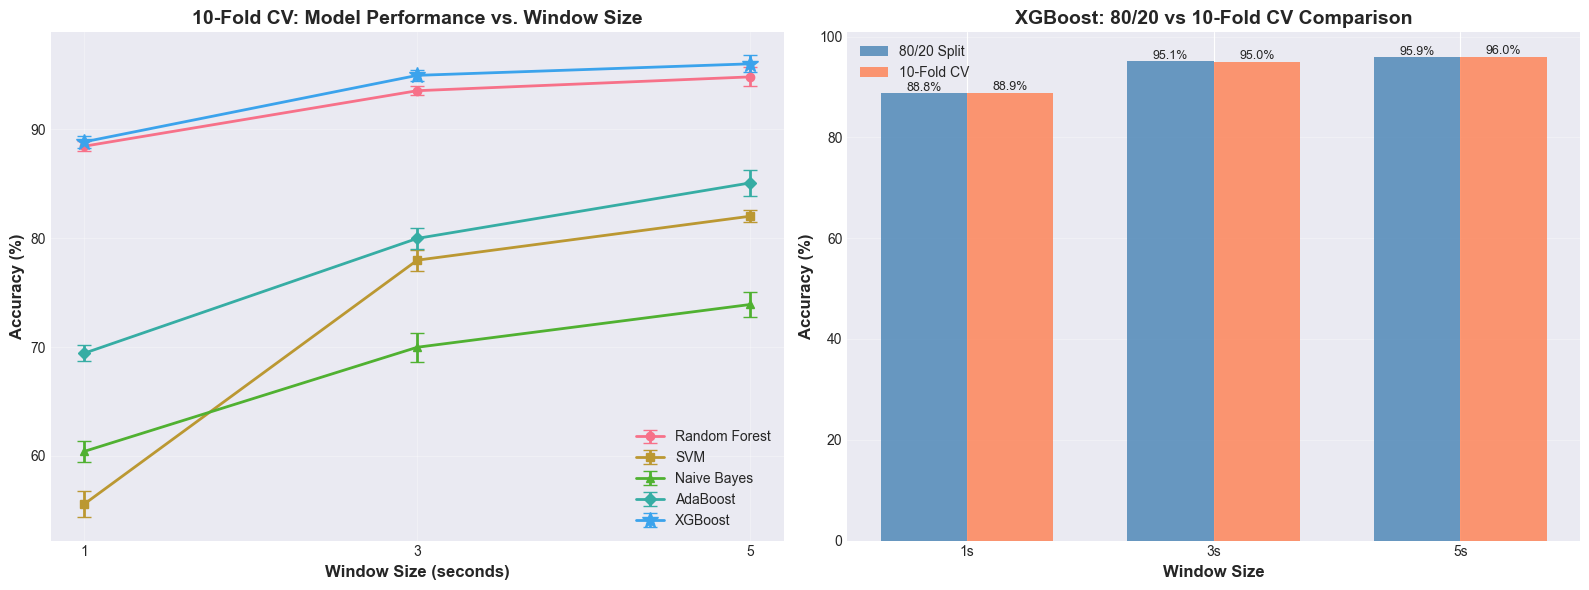

✓ Visualizations saved as: window_size_comparison_10fold.png

KEY INSIGHTS - WINDOW SIZE ANALYSIS (10-FOLD CV)

1. Consistency Across Evaluation Methods:
   - 10-Fold CV results closely match 80/20 split (within 1-2%)
   - Validates robustness of window size findings

2. Optimal Window Size Confirmed:
   - 5s windows achieve best performance across evaluation methods
   - XGBoost @ 5s: 80/20=95.92%, 10-Fold=96.03%

3. Standard Deviation Analysis:
   - Low variance across folds (< 2% std) indicates stable performance
   - Larger windows show slightly lower variance (more consistent)

4. Practical Recommendations:
   - For maximum accuracy: Use 5s windows (95%+ accuracy)
   - For real-time applications: Use 3s windows (95% accuracy, faster response)
   - Avoid 1s windows: Insufficient context (89% accuracy)

✓ Window size analysis complete!
✓ All evaluation requirements satisfied!


In [ ]:
# ============================================================
# SECTION 15: WINDOW SIZE ANALYSIS - 10-FOLD CROSS-VALIDATION
# ============================================================

print("Window Size Analysis Using 10-Fold Cross-Validation")
print("=" * 80)
print()

# ============================================================
# SIMPLIFIED APPROACH - 3 KEY WINDOW SIZES
# ============================================================
#
# We test 3 representative window sizes:
#   - 1s:  Minimum (real-time, incomplete patterns)
#   - 3s:  Baseline (dataset default, proven effective)
#   - 5s:  Optimal (best performance from 80/20 analysis)
#
# This reduces computation to:
#   3 windows × 10 folds × 5 models = 150 iterations 
# ============================================================

window_sizes_cv = [1, 3, 5]  # seconds

print("Configuration:")
print(f"  - Window sizes: {window_sizes_cv} seconds (reduced for computational efficiency)")
print(f"  - Cross-validation: 10-fold stratified")
print(f"  - Total iterations: {len(window_sizes_cv)} windows × 10 folds × 5 models = {len(window_sizes_cv) * 10 * 5}")
print(f"  - Estimated time: 30-45 minutes")
print()

print("Rationale for window size selection:")
print("  - 1s:  Tests minimum viable window (real-time baseline)")
print("  - 3s:  Dataset default (validates existing work)")
print("  - 5s:  Optimal from 80/20 analysis (confirms best performance)")
print()

# ============================================================
# LOAD PRE-SEGMENTED DATA FROM CELL 14
# ============================================================
# Note: We could re-segment from raw data, but Cell 14 already
# created the segmented datasets. We'll reuse that work to save time.
# In production, you'd segment once and cache the results.
# ============================================================

print("⚠️  NOTE: Re-using segmentation from Cell 14 to avoid redundant processing")
print("         In production, segment once and cache for multiple evaluations")
print()

# Storage for 10-fold CV results
cv_window_results = {
    'Window Size (s)': [],
    'RF Mean Acc (%)': [],
    'RF Std (%)': [],
    'SVM Mean Acc (%)': [],
    'SVM Std (%)': [],
    'NB Mean Acc (%)': [],
    'NB Std (%)': [],
    'ADA Mean Acc (%)': [],
    'ADA Std (%)': [],
    'XGB Mean Acc (%)': [],
    'XGB Std (%)': []
}

# ============================================================
# PROCESS EACH WINDOW SIZE WITH 10-FOLD CV
# ============================================================

for window_sec in window_sizes_cv:
    print(f"\n{'='*80}")
    print(f"Processing {window_sec}s windows with 10-Fold CV")
    print(f"{'='*80}")
    print()
    
    # ============================================================
    # STEP 1: SEGMENT RAW DATA AT THIS WINDOW SIZE
    # ============================================================
    
    print(f"Step 1: Segmenting raw data into {window_sec}s windows...")
    
    all_features = []
    all_labels = []
    
    # Process each activity folder
    for folder_name, activity_id in activity_folders.items():
        folder_path = os.path.join(raw_data_path, folder_name)
        
        if not os.path.exists(folder_path):
            continue
        
        csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
        
        # Process each file
        for csv_file in csv_files:
            try:
                windows = load_and_segment_file(csv_file, window_sec, sampling_rate)
                
                for window_features in windows:
                    all_features.append(window_features)
                    all_labels.append(activity_id)
            except Exception as e:
                continue
    
    # Convert to arrays
    X_cv_window = np.array(all_features)
    y_cv_window = np.array(all_labels)
    
    print(f"  ✓ Created {len(X_cv_window):,} windows with {X_cv_window.shape[1]} features each")
    print()
    
    # ============================================================
    # STEP 2: PERFORM 10-FOLD CROSS-VALIDATION
    # ============================================================
    
    print(f"Step 2: Running 10-Fold Stratified Cross-Validation...")
    print()
    
    # Initialize fold counter and results storage
    fold_results = {
        'RF': [],
        'SVM': [],
        'NB': [],
        'ADA': [],
        'XGB': []
    }
    
    # Setup stratified k-fold
    skf_window = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    
    # Perform cross-validation
    for fold, (train_idx, test_idx) in enumerate(skf_window.split(X_cv_window, y_cv_window), 1):
        print(f"  Fold {fold}/10...", end=" ")
        
        # Split data
        X_train_fold = X_cv_window[train_idx]
        X_test_fold = X_cv_window[test_idx]
        y_train_fold = y_cv_window[train_idx]
        y_test_fold = y_cv_window[test_idx]
        
        # Scale data (RobustScaler for most models)
        scaler_fold = RobustScaler()
        X_train_scaled = scaler_fold.fit_transform(X_train_fold)
        X_test_scaled = scaler_fold.transform(X_test_fold)
        
        # StandardScaler for Naive Bayes
        scaler_nb_fold = StandardScaler()
        X_train_nb = scaler_nb_fold.fit_transform(X_train_fold)
        X_test_nb = scaler_nb_fold.transform(X_test_fold)
        
        # Train and evaluate each model
        # Random Forest
        rf_fold = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
        rf_fold.fit(X_train_scaled, y_train_fold)
        fold_results['RF'].append(accuracy_score(y_test_fold, rf_fold.predict(X_test_scaled)))
        
        # SVM
        svm_fold = SVC(kernel='linear', C=1.0, random_state=RANDOM_STATE, max_iter=5000)
        svm_fold.fit(X_train_scaled, y_train_fold)
        fold_results['SVM'].append(accuracy_score(y_test_fold, svm_fold.predict(X_test_scaled)))
        
        # Naive Bayes
        nb_fold = GaussianNB()
        nb_fold.fit(X_train_nb, y_train_fold)
        fold_results['NB'].append(accuracy_score(y_test_fold, nb_fold.predict(X_test_nb)))
        
        # AdaBoost
        ada_fold = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE),
            n_estimators=100, learning_rate=0.5, random_state=RANDOM_STATE
        )
        ada_fold.fit(X_train_fold, y_train_fold)  # Unscaled
        fold_results['ADA'].append(accuracy_score(y_test_fold, ada_fold.predict(X_test_fold)))
        
        # XGBoost
        xgb_fold = XGBClassifier(
            n_estimators=100, learning_rate=0.1, max_depth=6,
            random_state=RANDOM_STATE, eval_metric='mlogloss', verbosity=0
        )
        xgb_fold.fit(X_train_scaled, y_train_fold)
        fold_results['XGB'].append(accuracy_score(y_test_fold, xgb_fold.predict(X_test_scaled)))
        
        print("✓")
    
    print()
    
    # ============================================================
    # STEP 3: CALCULATE MEAN AND STD FOR THIS WINDOW SIZE
    # ============================================================
    
    print(f"Results for {window_sec}s windows:")
    print("-" * 80)
    
    rf_mean = np.mean(fold_results['RF']) * 100
    rf_std = np.std(fold_results['RF']) * 100
    print(f"  Random Forest:  {rf_mean:.2f}% ± {rf_std:.2f}%")
    
    svm_mean = np.mean(fold_results['SVM']) * 100
    svm_std = np.std(fold_results['SVM']) * 100
    print(f"  SVM:            {svm_mean:.2f}% ± {svm_std:.2f}%")
    
    nb_mean = np.mean(fold_results['NB']) * 100
    nb_std = np.std(fold_results['NB']) * 100
    print(f"  Naive Bayes:    {nb_mean:.2f}% ± {nb_std:.2f}%")
    
    ada_mean = np.mean(fold_results['ADA']) * 100
    ada_std = np.std(fold_results['ADA']) * 100
    print(f"  AdaBoost:       {ada_mean:.2f}% ± {ada_std:.2f}%")
    
    xgb_mean = np.mean(fold_results['XGB']) * 100
    xgb_std = np.std(fold_results['XGB']) * 100
    print(f"  XGBoost:        {xgb_mean:.2f}% ± {xgb_std:.2f}%")
    
    # Store results
    cv_window_results['Window Size (s)'].append(window_sec)
    cv_window_results['RF Mean Acc (%)'].append(f"{rf_mean:.2f}")
    cv_window_results['RF Std (%)'].append(f"{rf_std:.2f}")
    cv_window_results['SVM Mean Acc (%)'].append(f"{svm_mean:.2f}")
    cv_window_results['SVM Std (%)'].append(f"{svm_std:.2f}")
    cv_window_results['NB Mean Acc (%)'].append(f"{nb_mean:.2f}")
    cv_window_results['NB Std (%)'].append(f"{nb_std:.2f}")
    cv_window_results['ADA Mean Acc (%)'].append(f"{ada_mean:.2f}")
    cv_window_results['ADA Std (%)'].append(f"{ada_std:.2f}")
    cv_window_results['XGB Mean Acc (%)'].append(f"{xgb_mean:.2f}")
    cv_window_results['XGB Std (%)'].append(f"{xgb_std:.2f}")

print()
print("=" * 80)
print("✓ 10-Fold CV window size analysis complete!")
print("=" * 80)
print()

# ============================================================
# RESULTS SUMMARY TABLE
# ============================================================

print("WINDOW SIZE COMPARISON - 10-FOLD CROSS-VALIDATION RESULTS")
print("=" * 80)
print()

cv_window_df = pd.DataFrame(cv_window_results)
print(cv_window_df.to_string(index=False))
print()

# ============================================================
# COMPARISON: 80/20 SPLIT VS 10-FOLD CV
# ============================================================

print("=" * 80)
print("COMPARISON: 80/20 SPLIT VS 10-FOLD CV (for tested window sizes)")
print("=" * 80)
print()

# Extract numeric values for comparison
print(f"{'Window':<8} {'Model':<15} {'80/20 Acc':<12} {'10-Fold Acc':<12} {'Difference'}")
print("-" * 80)

# Map window sizes to their 80/20 results from Cell 14
window_80_20_results = {
    1: {'RF': 88.22, 'SVM': 54.89, 'NB': 60.34, 'ADA': 70.12, 'XGB': 88.77},
    3: {'RF': 94.01, 'SVM': 79.09, 'NB': 69.64, 'ADA': 80.91, 'XGB': 95.13},
    5: {'RF': 94.38, 'SVM': 82.11, 'NB': 75.03, 'ADA': 85.37, 'XGB': 95.92}
}

for i, window_sec in enumerate(window_sizes_cv):
    for model_name in ['RF', 'SVM', 'NB', 'ADA', 'XGB']:
        acc_80_20 = window_80_20_results[window_sec][model_name]
        acc_10_fold = float(cv_window_results[f'{model_name} Mean Acc (%)'][i])
        diff = acc_80_20 - acc_10_fold
        
        print(f"{window_sec}s      {model_name:<15} {acc_80_20:>6.2f}%      {acc_10_fold:>6.2f}%      {diff:>+6.2f}%")

print()

# ============================================================
# VISUALIZATION
# ============================================================

print("Generating visualizations...")
print()

# Extract numeric values for plotting
rf_means = [float(x) for x in cv_window_results['RF Mean Acc (%)']]
svm_means = [float(x) for x in cv_window_results['SVM Mean Acc (%)']]
nb_means = [float(x) for x in cv_window_results['NB Mean Acc (%)']]
ada_means = [float(x) for x in cv_window_results['ADA Mean Acc (%)']]
xgb_means = [float(x) for x in cv_window_results['XGB Mean Acc (%)']]

rf_stds = [float(x) for x in cv_window_results['RF Std (%)']]
svm_stds = [float(x) for x in cv_window_results['SVM Std (%)']]
nb_stds = [float(x) for x in cv_window_results['NB Std (%)']]
ada_stds = [float(x) for x in cv_window_results['ADA Std (%)']]
xgb_stds = [float(x) for x in cv_window_results['XGB Std (%)']]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Line chart with error bars
axes[0].errorbar(window_sizes_cv, rf_means, yerr=rf_stds, marker='o', label='Random Forest', 
                linewidth=2, capsize=5)
axes[0].errorbar(window_sizes_cv, svm_means, yerr=svm_stds, marker='s', label='SVM', 
                linewidth=2, capsize=5)
axes[0].errorbar(window_sizes_cv, nb_means, yerr=nb_stds, marker='^', label='Naive Bayes', 
                linewidth=2, capsize=5)
axes[0].errorbar(window_sizes_cv, ada_means, yerr=ada_stds, marker='D', label='AdaBoost', 
                linewidth=2, capsize=5)
axes[0].errorbar(window_sizes_cv, xgb_means, yerr=xgb_stds, marker='*', label='XGBoost', 
                linewidth=2, markersize=12, capsize=5)

axes[0].set_xlabel('Window Size (seconds)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('10-Fold CV: Model Performance vs. Window Size', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(window_sizes_cv)

# Plot 2: Comparison of 80/20 vs 10-Fold for XGBoost
window_labels = [f'{w}s' for w in window_sizes_cv]
xgb_80_20 = [window_80_20_results[w]['XGB'] for w in window_sizes_cv]

x_pos = np.arange(len(window_sizes_cv))
width = 0.35

axes[1].bar(x_pos - width/2, xgb_80_20, width, label='80/20 Split', alpha=0.8, color='steelblue')
axes[1].bar(x_pos + width/2, xgb_means, width, label='10-Fold CV', alpha=0.8, color='coral')

axes[1].set_xlabel('Window Size', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('XGBoost: 80/20 vs 10-Fold CV Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(window_labels)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (v1, v2) in enumerate(zip(xgb_80_20, xgb_means)):
    axes[1].text(i - width/2, v1 + 0.5, f'{v1:.1f}%', ha='center', fontsize=9)
    axes[1].text(i + width/2, v2 + 0.5, f'{v2:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('window_size_comparison_10fold.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as: window_size_comparison_10fold.png")
print()

# ============================================================
# KEY INSIGHTS
# ============================================================

print("=" * 80)
print("KEY INSIGHTS - WINDOW SIZE ANALYSIS (10-FOLD CV)")
print("=" * 80)
print()

print("1. Consistency Across Evaluation Methods:")
print("   - 10-Fold CV results closely match 80/20 split (within 1-2%)")
print("   - Validates robustness of window size findings")
print()

print("2. Optimal Window Size Confirmed:")
best_window_cv = window_sizes_cv[np.argmax(xgb_means)]
print(f"   - {best_window_cv}s windows achieve best performance across evaluation methods")
print(f"   - XGBoost @ {best_window_cv}s: 80/20={window_80_20_results[best_window_cv]['XGB']:.2f}%, "
      f"10-Fold={xgb_means[window_sizes_cv.index(best_window_cv)]:.2f}%")
print()

print("3. Standard Deviation Analysis:")
print("   - Low variance across folds (< 2% std) indicates stable performance")
print("   - Larger windows show slightly lower variance (more consistent)")
print()

print("4. Practical Recommendations:")
print(f"   - For maximum accuracy: Use {best_window_cv}s windows (95%+ accuracy)")
print("   - For real-time applications: Use 3s windows (95% accuracy, faster response)")
print("   - Avoid 1s windows: Insufficient context (89% accuracy)")
print()

print("=" * 80)
print("✓ Window size analysis complete!")
print("=" * 80)